# Initial Block

In [0]:
import os
import glob
import time
import joblib
from getpass import getpass
from google.colab import drive





drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/coco_segment/")

print("DO NOT LEAVE ./coco_segment  directory")
print("Switched to ",os.getcwd())


########################
### switch directory ###
########################

def switch_directory(ip=None, getPath=False, verbose=False):
  d = {}

  l = [
      "/content/drive/My Drive/coco_segment/", #0
      "/content/drive/My Drive/coco_segment/coco_seg/", #1
      "/content/drive/My Drive/coco_segment/coco_seg/picklefiles/", #2
      "/content/drive/My Drive/coco_segment/coco_seg/picklefiles/1CH_train_masks/", #3
      "/content/drive/My Drive/coco_segment/coco_seg/picklefiles/1CH_val_masks/", #4
      "/content/drive/My Drive/coco_segment/data/coco/annotations/instances_train2017.json", #5
      "/content/drive/My Drive/coco_segment/data/coco/annotations/instances_val2017.json", #6
  ]

  for x,i in enumerate(l):
      d[x] = i
      if verbose:
        print(x, i)
  
  d["root"] = "/content/drive/My Drive/"
  
  
  if getPath:
    return d[ip]
  
  
  if ip == None:
    
    # print(d)

    ip = int(input("Enter path number "))
    os.chdir(d[ip])
  
  else:
    os.chdir(d[ip])  
    
  
  print("Switched to: ", os.getcwd())
  
  return os.getcwd()

switch_directory(1)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
DO NOT LEAVE ./coco_segment  directory
Switched to  /content/drive/My Drive/coco_segment
Switched to:  /content/drive/My Drive/coco_segment/coco_seg


'/content/drive/My Drive/coco_segment/coco_seg'

# Libraries

In [0]:
import pandas as pd
import numpy as np
import json


import matplotlib.pyplot as plt
import tensorflow as tf

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from glob import glob



# Custom Libraries

In [0]:
switch_directory(1)
from loadData import CocoHelper, LoadBin



dataDir = "../data/coco/"

# (dataDir='../data/coco/', dataType=['train2017', 'val2017'])
co_ob = CocoHelper(dataDir)
ld_bin_ob = LoadBin()


coco1, coco2 = co_ob.coco1, co_ob.coco2  # train, val objects of coco
cc1 = co_ob.coco1['loaded_annFile']
cc2 = co_ob.coco2['loaded_annFile']  # train, val loaded annotations

Switched to:  /content/drive/My Drive/coco_segment/coco_seg
loading annotations into memory...
Done (t=21.73s)
creating index...
index created!

loading annotations into memory...
Done (t=2.86s)
creating index...
index created!



# Utilities

In [0]:
########################################
######### READ JSON FILE ###############
########################################

def read_json(path):
  """
  Read json file
  
  args: 
    path: path to required file
  returns:
    dict
  """
  with open(path,"r") as json_file:
    d = json.load(json_file)
    
    print(d.keys())
    return d
  
  
########################################
######### GET TRAIN VAL DF #############
########################################
def get_reqd_train_val_df(img_path_df, category_name, cat_id=None):
  
  pattern1 = "./picklefiles/train_dataframes/train_"+category_name+"_df.*"  
  pattern2 = "./picklefiles/val_dataframes/val_"+category_name+"_df.*"  
  
  for i in glob(pattern1):
    p1 = i
  
  for i in glob(pattern2):
    p2 = i
  
  print(p1)
  print(p2)
  
  train_df = joblib.load(p1)
  val_df = joblib.load(p2)
  
  ctrain_df = pd.merge(train_df,img_path_df,on="id", how="left")
  ctrain_df = ctrain_df.drop(columns=['license','date_captured'])

  cval_df = pd.merge(val_df, img_path_df, on="id", how="left", )
  cval_df = cval_df.drop(columns=['license','date_captured'])
  return (ctrain_df, cval_df)

########################################
######### PROC IMG MASK ################
########################################
def resize_image(a,newshape, is_mask=False):
  if is_mask:
    newshape_mask = (newshape[0],newshape[1],1)
    return resize(a,output_shape=newshape_mask)
  else:
    return resize(a,output_shape=newshape)

def to_float(a):
  return np.float32(a)


def preprocess_nn(a,newshape, is_mask=False):
  a = to_float(a)
  a = resize_image(a,newshape,is_mask)
  
  return a

def reshape_fit(a):
  a = np.array([a])
  return a

########################################
######### LOAD IMG MASK ################
########################################

def load_image_mask_online(coco, co_ob, img_id, cat_id, img_path_df, master_df, newshape=(640,640,3)):
  t = img_path_df[img_path_df['id'] == img_id]
  
  req_url = t['coco_url'].values[0]
  # print(req_url)
  
  
  img = io.imread(req_url)
  mask = co_ob.get_mask_of_image(coco, img_id, cat_id=cat_id, img_path_df=img_path_df, master_df=train_master_df)
  
  img = preprocess_nn(img, newshape)
  mask = preprocess_nn(mask, newshape, is_mask=True)
  
  return (img,mask)

  
########################################
######### PLOT IMG MASK ################
########################################
  
def plot_img_and_mask(img,mask):
  """
  Visualise image and it's mask
  args:
    img: image (numpy array)
    mask: reqd mask of image (numpy array)
  returns:
    matplotlib plot of img and mask
  """

  I = img

  f, ax = plt.subplots(1, 2)
  ax[0].imshow((I).astype(np.int32))
  ax[1].imshow(np.uint8(np.squeeze(mask)*255))
  
  plt.plot()


# Load required Binaries

In [0]:
s = time.time()


c = joblib.load("./picklefiles/DICT")
rc = joblib.load("./picklefiles/REVERSE_DICT")

# dataframes
img_path_df = joblib.load("./picklefiles/img_df_anno_all") # must contain path("local") and coco_url

train_master_df = joblib.load("./picklefiles/train_master_df")
val_master_df = joblib.load("./picklefiles/val_master_df")


# loading annotations

# cc1 = joblib.load("./picklefiles/cc_train")
# cc2 = joblib.load("./picklefiles/cc_val")


# ann_train = joblib.load("./picklefiles/train_annotations.bin")
# ann_val = joblib.load("./picklefiles/val_annotations.bin")

# ann_train = read_json(switch_directory(5,getPath=True))
# ann_val = read_json(switch_directory(6,getPath=True))


e = time.time()
print("Time required to load binaries: ", e-s, "seconds")


# print("Remove Docstrings to execute")

Time required to load binaries:  2.8420746326446533 seconds


In [0]:
"""
with open('instances_train2017.json', 'w') as fp:

    json.dump(ann_train, fp)
"""
"""
with open('instances_val2017.json', 'w') as fp:

    json.dump(ann_val, fp)
"""
print("Remove Docstrings to execute")
  

Remove Docstrings to execute


# Image Path Dataframe

In [0]:
# print("IMAGE PATH DATAFRAME TRAIN+VAL")
# img_path_df.head()

# Loading required training and validation ids

In [0]:
r_df_train, r_df_val = get_reqd_train_val_df(img_path_df,"car")

./picklefiles/train_dataframes/train_car_df.3
./picklefiles/val_dataframes/val_car_df.3


# Loading Masks

In [0]:
img_id = 349363
cat_id = 3
master_df = train_master_df # or val_master_df

# preprocessed image and mask
r_img, r_mask = load_image_mask_online(cc1, co_ob, img_id, cat_id, img_path_df, master_df)

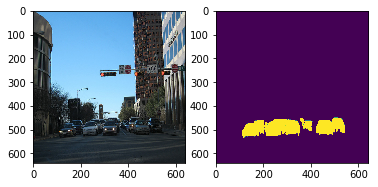

In [0]:
plot_img_and_mask(r_img,r_mask)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Batching

In [0]:
# fetching person category
r_df_train, r_df_val = get_reqd_train_val_df(img_path_df,"person")
r_df_train.shape

./picklefiles/train_dataframes/train_person_df.1
./picklefiles/val_dataframes/val_person_df.1


(64115, 8)

In [0]:
train_imgs, train_masks = [], []
val_imgs, val_masks = [], []

cat_id = 1
master_df = train_master_df
img_ids = r_df_train['id'][:100].values

for i in img_ids:
  r_img, r_mask = load_image_mask_online(cc1, co_ob, i, cat_id, img_path_df, master_df)
  train_imgs.append(reshape_fit(r_img))
  train_masks.append(reshape_fit(r_mask))